# Week 3 Lecture Notes

This week, we dive deeper into the **practical mechanics of text mining** by working with real-world app reviews from the Google Play Store. You’ll learn how to collect and process raw text data, transform it into structured numerical representations (using techniques like **TF**, **TF-IDF**, and **sparse vectors**), and use these representations to perform tasks such as **sentiment scoring** and **document clustering**. We’ll also explore cosine similarity and apply **K-means clustering** to uncover hidden patterns in user feedback — skills that form the foundation of many real-world text analytics applications.

## Downloading a Corpus of Google Play Store Reviews

Today, we are going to be analyzing some reviews downloaded from the Google Play Store.

### Google Play Scraper

`google-play-scraper` is a Python library that allows you to programmatically access data from the Google Play Store. You can use it to retrieve app information, ratings, and — most importantly for us — user reviews. This makes it a useful tool for collecting real-world text data that we can analyze using sentiment analysis techniques.

### PIP

`pip` is the standard package manager for Python. It allows you to install and manage additional libraries and tools that aren't included in the Python standard library. Think of it like an app store for Python packages — you can use it to quickly add functionality to your projects, like downloading datasets, building models, or scraping websites.

Normally, you would run `pip` commands in your computer's terminal or command prompt — for example, by typing `pip install package-name` into a command line window. However, since we're using **Google Colab**, we can run shell commands directly in notebook cells by adding an exclamation mark (`!`) at the beginning. This tells Colab to treat the line as a terminal command instead of Python code.

In the cell below, we're using `pip` to install the `google-play-scraper` package so we can fetch app reviews from the Google Play Store. This step ensures the library is available in our Colab environment.



In [1]:
!pip install google-play-scraper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB/s eta 0:00:00



### Import Google Play Scraper

After installing a library with `pip`, we still need to **import** it into our Python environment to use its functions. The line `import google_play_scraper` makes the package available in our code so we can start using it.



In [2]:
import google_play_scraper



### Download Reviews

The code below uses the `reviews_all()` function from the `google_play_scraper` library to download all available user reviews for a specific app. In this case, we're fetching reviews for the **TD Bank** mobile app, which has the app ID `'com.td'`.

We also specify:
- `lang='en'` to get reviews written in English (default is English)
- `country='ca'` to get reviews from the Canadian version of the Play Store (default is the U.S.)

The result is a list of dictionaries, where each dictionary contains details about a single review — including the review text, rating, date, and more.



In [3]:
reviews = google_play_scraper.reviews_all(
    'com.td',
    lang='en', # defaults to 'en'
    country='ca', # defaults to 'us'
)



After downloading the reviews, we can use `len(reviews)` to see how many reviews were returned. This tells us the total number of reviews collected for the app.



In [4]:
len(reviews)


40149


To inspect the content, we can look at a few examples using slicing. For example, `reviews[0:3]` will display the first three reviews in the list. Each review is stored as a dictionary containing fields like the review text (`content`), rating (`score`), and timestamp (`at`).



In [5]:
reviews[0:3]


[{'reviewId': '00555d90-ed95-4a92-86fa-2bd770f05c17',
  'userName': 'A Google user',
  'userImage': 'https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g',
  'content': 'Clients have choices. You have to love that.',
  'score': 5,
  'thumbsUpCount': 0,
  'reviewCreatedVersion': '25.04.0',
  'at': datetime.datetime(2025, 5, 18, 13, 59, 2),
  'replyContent': None,
  'repliedAt': None,
  'appVersion': '25.04.0'},
 {'reviewId': '4b5be64b-baa2-4276-b131-be3e40469cf1',
  'userName': 'A Google user',
  'userImage': 'https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g',
  'content': 'good',
  'score': 4,
  'thumbsUpCount': 0,
  'reviewCreatedVersion': '25.04.0',
  'at': datetime.datetime(2025, 5, 18, 1, 42, 9),
  'replyContent': None,
  'repliedAt': None,
  'appVersion': '25.04.0'},
 {'reviewId': 'd89badc1-07b5-4df8-add4-575ff5fe01c4',
  'userName': 'A Google


## Creating a Tokenizer

To analyze these reviews we need to tokenize them. Here we're creating a simple **bag-of-words tokenizer** that splits a text into individual word tokens. We’ll **standardize** all tokens by converting them to lowercase — so that “Great” and “great” are treated as the same word.

We’re using the regular expression `\b\w+\b` to extract tokens:

- `\w+` matches one or more alphanumeric characters (letters, numbers, and underscores)
- `\b` marks a **word boundary**, so this pattern finds full word-like chunks and skips punctuation, symbols, and whitespace

After tokenizing, we'll remove some common stop words.

Our function `tokenize()` takes a string as input and returns a list of strings.



In [6]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def tokenize(text):
    lowercase_text = text.lower()
    tokens = re.findall(r'\b\w+\b', lowercase_text)
    return [t for t in tokens if t not in ENGLISH_STOP_WORDS]



Let's try tokenizing a sample document.



In [7]:
doc = "This app is incredibly frustrating. It keeps crashing every time I try to log in, and the new layout is confusing and slow. Terrible experience overall."
tokenize(doc)


['app',
 'incredibly',
 'frustrating',
 'keeps',
 'crashing',
 'time',
 'try',
 'log',
 'new',
 'layout',
 'confusing',
 'slow',
 'terrible',
 'experience',
 'overall']


## Sparse Vectors

As we discussed last class, when working with bag-of-words models, the next step after tokenization is to **vectorize** each document. You might think a list would be the most obvious way of storing a vector in Python.

But here’s the problem: most documents use only a small fraction of all the words in the full vocabulary. That means most of the values in these vectors are **zeros**.

This kind of structure is called a **sparse vector** — a vector where most of the entries are zero.

To save space and improve efficiency, we can represent sparse vectors using **dictionaries** in Python. Instead of storing every position, we only store the positions (words) that have non-zero values.

## Binary Vectorization

The `vectorize_binary` function creates a **binary (multi-hot) vector** from a list of tokens. This means it returns a dictionary where:

- Each **unique token** becomes a key
- The value is always `1`, indicating that the token is **present** in the document

This approach ignores how many times a word appears — it only cares **whether or not** the word is there. It's useful when we want to know which words are included but don’t need their exact frequency.

We use a Python `set` to remove duplicates, then build a dictionary where every token maps to the value `1`.



In [8]:
def vectorize_binary(tokens):
    """
    Takes a list of tokens and returns a dictionary representing
    a binary (multi-hot) vector — 1 if the word appears, 0 if not (implied).
    """
    return {token: 1 for token in set(tokens)}



Let's try an example:



In [9]:
doc = "This app is incredibly frustrating. It keeps crashing every time I try to log in, and the new layout is confusing and slow. Terrible experience overall."
tokens = tokenize(doc)
vectorize_binary(tokens)


{'app': 1,
 'terrible': 1,
 'crashing': 1,
 'time': 1,
 'try': 1,
 'log': 1,
 'experience': 1,
 'overall': 1,
 'keeps': 1,
 'new': 1,
 'slow': 1,
 'incredibly': 1,
 'layout': 1,
 'confusing': 1,
 'frustrating': 1}


## TF Vectorization

The `vectorize_tf` function creates a **term frequency (TF) vector** from a list of tokens. This means it returns a dictionary where:

- Each **unique token** becomes a key
- The value is the **number of times** that token appears in the document

Unlike binary (multi-hot) encoding, this approach **captures how often** each word occurs, which can give more nuanced insight into the text — especially when certain words are repeated for emphasis or importance.

We build this dictionary by looping through the tokens and counting how many times each one appears.



In [10]:
def vectorize_tf(tokens):
    """
    Takes a list of tokens and returns a dictionary representing
    term frequency (TF) — how many times each token appears.
    """
    tf = {}
    for token in tokens:
        if token in tf:
            tf[token] += 1
        else:
            tf[token] = 1
    return tf



Let's try an example:



In [11]:
doc = "This app is incredibly frustrating. It keeps crashing every time I try to log in, and the new layout is confusing and slow. Terrible experience overall."
tokens = tokenize(doc)
vectorize_tf(tokens)


{'app': 1,
 'incredibly': 1,
 'frustrating': 1,
 'keeps': 1,
 'crashing': 1,
 'time': 1,
 'try': 1,
 'log': 1,
 'new': 1,
 'layout': 1,
 'confusing': 1,
 'slow': 1,
 'terrible': 1,
 'experience': 1,
 'overall': 1}


## Calculating IDF

Before we can compute TF-IDF scores, we need to calculate **Inverse Document Frequency (IDF)** — a measure of how **rare or unique** a word is across all documents in the corpus.

Here’s what the code does step by step:

- `N = len(reviews)`  
  Counts the total number of documents (in this case, app reviews) in the corpus.

- We loop through each review and:
  - Use `tokenize()` to split the review into lowercase word tokens.
  - Convert the list of tokens into a `set` to get the **unique words** in that document.
  - For each unique word, we increase its **document frequency** — the number of documents in which the word appears.

- Finally, we calculate the **IDF score** for each token using the formula:  

  IDF = log(N / DF)
  
  Where:
  - `N` is the total number of documents
  - `DF(t)` is the number of documents containing token `t`

Words that appear in **fewer documents** get **higher IDF scores**, meaning they are considered more informative or unique. Common words that appear in many documents receive **lower scores**.




In [12]:
from math import log

N = len(reviews) # total number of documents

doc_freq = {} # document frequency for each word
for review in reviews:
  if not review['content']:
    continue # some reviews do not have any content, skip these
  doc = tokenize(review['content'])
  unique_tokens = set(doc) # only count once per document
  for token in unique_tokens:
      doc_freq[token] = doc_freq.get(token, 0) + 1

idf_dict = {}
for token, df in doc_freq.items():
    idf_dict[token] = log(N / df)



Let's see what our `idf_dict` looks like:




In [13]:
idf_dict


{'choices': 8.520911270784648,
 'love': 2.8636091300109885,
 'clients': 6.4732184274193925,
 'good': 2.44298237127771,
 'great': 1.9620044994917796,
 'easy': 1.7326436044250981,
 'app': 1.1695925950956882,
 'investments': 6.441469729104813,
 'bank': 2.6131680642310116,
 'dealing': 7.23305698247801,
 'various': 7.767139468408268,
 'use': 2.080363533746245,
 'rrif': 10.600352812464484,
 'need': 3.282476613837989,
 'managing': 7.26814830228928,
 'accounts': 4.040737574971242,
 'straight': 5.9852322956232245,
 'forwardto': 10.600352812464484,
 'institute': 9.214058451344593,
 'life': 4.857349624655002,
 'financial': 5.955961913323112,
 'excellent': 3.499500903520434,
 'week': 5.111415086307797,
 'quick': 3.5003256458352245,
 'really': 3.7673210796782834,
 'saves': 4.896570337808283,
 'going': 4.279584518213902,
 's': 2.5194963928234984,
 'look': 5.099094601919758,
 'way': 3.9683510350688542,
 'long': 4.606391385157915,
 'banking': 2.8706174810794334,
 'home': 4.692269874295553,
 'baby': 8.


This code displays the tokens with the lowest and highest IDF:



In [14]:
# Sort tokens by IDF score
sorted_idf = sorted(idf_dict.items(), key=lambda x: x[1])

# Lowest IDF scores (most common words)
print("🔽 5 Most Common Words (Lowest IDF):")
for token, score in sorted_idf[:5]:
    print(f"{token}: {score:.4f}")

# Highest IDF scores (most unique words)
print("\n🔼 5 Most Unique Words (Highest IDF):")
for token, score in sorted_idf[-5:]:
    print(f"{token}: {score:.4f}")



🔽 5 Most Common Words (Lowest IDF):
app: 1.1696
easy: 1.7326
great: 1.9620
t: 1.9793
use: 2.0804

🔼 5 Most Unique Words (Highest IDF):
drawables: 10.6004
balences: 10.6004
nerds: 10.6004
cleanup: 10.6004
fraction: 10.6004



## TF-IDF Vectorization

The `vectorize_tf_idf` function creates a **TF-IDF vector** from a list of tokens. This means it returns a dictionary where:

- Each **unique token** becomes a key
- The value is the product of the token’s **term frequency (TF)** and its **inverse document frequency (IDF)**

TF-IDF scores reflect not just how often a word appears in a document, but also how **informative or distinctive** that word is across the entire corpus. Words that appear frequently in a document but rarely in others will have the **highest TF-IDF scores**.

We first count how many times each word appears (TF), then multiply that by its IDF value (from the `idf_dict`). Tokens that don’t appear in the IDF dictionary are ignored.



In [15]:
def vectorize_tf_idf(tokens):
    """
    Takes a list of tokens and an IDF dictionary,
    returns a dictionary representing the TF-IDF vector.
    """
    tf = {}
    for token in tokens:
        if token in tf:
            tf[token] += 1
        else:
            tf[token] = 1

    tf_idf = {}
    for token, freq in tf.items():
        if token in idf_dict:
            tf_idf[token] = freq * idf_dict[token]

    return tf_idf



Let's try an example:



In [16]:
doc = "This app is incredibly frustrating. It keeps crashing every time I try to log in, and the new layout is confusing and slow. Terrible experience overall."
tokens = tokenize(doc)
vectorize_tf_idf(tokens)


{'app': 1.1695925950956882,
 'incredibly': 6.243643985774892,
 'frustrating': 4.451884516546837,
 'keeps': 3.76194761161714,
 'crashing': 4.816527630134747,
 'time': 2.5145581111829154,
 'try': 3.687609991971308,
 'log': 3.1020369416975027,
 'new': 3.5194849157737025,
 'layout': 6.015385333793912,
 'confusing': 6.522815368558764,
 'slow': 4.703198944827744,
 'terrible': 4.745280890262057,
 'experience': 3.950073763877062,
 'overall': 5.297047904405408}


## Downloading a Lexicon

We’re going to analyze the app reviews' sentiment using a **lexicon-based approach**. That means we'll score each review based on the words it contains, using a predefined list of words (a *lexicon*) where each word has an associated sentiment score.

To do this, we’ll first download a **lexicon file** that I’ve provided for the course.

The command below uses `wget` to download the file from GitHub:



In [17]:
!wget https://raw.githubusercontent.com/wd13ca/BAN200-Summer-2025/refs/heads/main/lexicon.txt


--2025-05-20 02:18:53--  https://raw.githubusercontent.com/wd13ca/BAN200-Summer-2025/refs/heads/main/lexicon.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105077 (103K) [text/plain]
Saving to: ‘lexicon.txt’

lexicon.txt         100%[===================>] 102.61K  --.-KB/s    in 0.02s   

2025-05-20 02:18:53 (6.21 MB/s) - ‘lexicon.txt’ saved [105077/105077]




Note that this is not a Python command — it’s a shell command that we’re running inside Colab by prefixing it with an exclamation mark (!). This tells Colab to treat the line as if it were typed into a terminal.

The file lexicon.txt is a tab-delimited text file with two columns:

- The first column is a word (e.g., great, terrible, fast)
- The second column is the word’s sentiment score — a number that represents how positive or negative that word is

We’ll load this lexicon into Python and use it to calculate sentiment scores for app reviews.

The code below reads the `lexicon.txt` file and stores its contents in a Python dictionary called `lexicon`.

Here’s what each part does:

- `with open("lexicon.txt", "r") as file:`  
  Opens the file in read mode. The `with` statement ensures the file is properly closed after reading.

- `for line in file:`  
  Loops through each line in the file. Each line contains one word and its sentiment score.

- `line.strip().split('\t')`  
  Removes any extra whitespace (like newlines) and splits the line into two parts using the **tab character** (`\t`) as the separator.

- `lexicon[word] = float(score)`  
  Adds the word to the dictionary, with its sentiment score stored as a floating-point number.

Once this code runs, you’ll have a dictionary where each word maps to a numeric sentiment score — ready to use for scoring reviews.




In [18]:
lexicon = {}

with open("lexicon.txt", "r") as file:
    for line in file:
        word, score = line.strip().split('\t')
        lexicon[word] = float(score)



Let's take a look at our `lexicon`:



In [19]:
lexicon


{"---'-;-{@": 2.3,
 '--<--<@': 2.2,
 ',-:': 1.2,
 ';-)': 1.0,
 ';-]': 0.7,
 ';-*': 2.2,
 ';)': 0.9,
 ';]': 0.6,
 ';^)': 1.4,
 ';d': 0.8,
 ';D': 0.8,
 ':-,': 1.1,
 ':-.': -0.9,
 ':-(': -1.5,
 ':-)': 1.3,
 ':-))': 2.8,
 ':-[': -1.6,
 ':-*': 1.7,
 ':-/': -1.2,
 ':-\\': -0.9,
 ':-&': -0.5,
 ':-###..': -2.5,
 ':-<': -1.5,
 ':-|': -0.7,
 ':-||': -2.5,
 ':-c': -1.3,
 ':-d': 2.3,
 ':-D': 2.3,
 ':-o': 0.1,
 ':-p': 1.5,
 ':-Þ': 0.9,
 ':?)': 1.3,
 ':?c': -1.6,
 ":'-(": -2.4,
 ":'-)": 2.7,
 ":'(": -2.2,
 ":')": 2.3,
 ':(': -1.9,
 ':)': 2.0,
 ':[': -2.0,
 ':]': 2.2,
 ':{': -1.9,
 ':}': 2.1,
 ':@': -2.5,
 ':*': 2.5,
 ':/': -1.4,
 ':\\': -1.3,
 ':&': -0.6,
 ':###..': -2.4,
 ':^)': 2.1,
 ':^*': 2.6,
 ':^/': -1.2,
 ':^\\': -1.0,
 ':^|': -1.0,
 ':<': -2.1,
 ':>': 2.1,
 ':|': -0.4,
 ':$': -0.2,
 ':3': 2.3,
 ':c': -2.1,
 ':c)': 2.0,
 ':d': 2.3,
 ':D': 2.3,
 ':l': -1.7,
 ':o': -0.4,
 ':o)': 2.1,
 ':o/': -1.4,
 ':o\\': -1.1,
 ':o|': -0.6,
 ':p': 1.0,
 ':P': 1.4,
 ':s': -1.2,
 ':Þ': 1.1,
 '.-:': -1.2,
 '..##


## Sparse Dot Product

The `sparse_dot_product` function calculates the **dot product** of two sparse vectors, which are represented as Python dictionaries.

The dot product multiplies matching values from both vectors and sums the results. In our case:

- The keys of the dictionaries are the tokens
- The values are numbers like term frequency, TF-IDF scores, or sentiment weights

Only **tokens that appear in both vectors** contribute to the result — which makes this efficient for sparse data. We are assuming that if a key doesn't appear in a vector, it has a value of zero.



In [20]:
def sparse_dot_product(vec1, vec2):
    """
    Computes the dot product of two sparse vectors (dicts).
    Only keys that appear in both vectors contribute to the result.
    """
    return sum(vec1[token] * vec2[token] for token in vec1 if token in vec2)



Let's take a look at an example:



In [21]:
vec1 = {'great': 2.0, 'battery': 1.0, 'screen': 0.5}
vec2 = {'great': 1.0, 'battery': 1.0, 'performance': 0.3}

dot = sparse_dot_product(vec1, vec2)
print(dot)


3.0



## Calculating Sentiment Scores

To compute the **sentiment score** of a document, we can take the **dot product** of two sparse vectors:

1. A **document vector**, which represents the words in the document (e.g., using term frequency or TF-IDF)
2. A **sentiment lexicon vector**, which assigns a sentiment score (positive, negative, or neutral) to each word

Each word in the vocabulary contributes to the sentiment score based on how often it appears in the document and how emotionally charged it is.

How It Works:

- For each word in the document, multiply its **frequency** (or weight) by its **sentiment score** from the lexicon.
- Add up all those products — that’s the total sentiment score.

This is exactly what a **dot product** does:

`sentiment_score = dot_product(document_vector, sentiment_lexicon)`

Only words that appear in **both** the document and the lexicon contribute to the result, making this efficient and interpretable.

Interpretation:
- A **positive score** indicates positive sentiment
- A **negative score** indicates negative sentiment
- A score of **zero** (or near zero) is neutral or mixed

Let's take a look at an example:



In [22]:
doc = "This app is incredibly frustrating. It keeps crashing every time I try to log in, and the new layout is confusing and slow. Terrible experience overall."
doc_tokens = tokenize(doc)
doc_vector = vectorize_tf_idf(doc_tokens)

sparse_dot_product(lexicon, doc_vector)



-24.2942042826922


## Evaluating Our Lexicon Model on TD App Reviews

Each review from the Google Play Store includes a **star rating** from 1 to 5, given by the user.

We can use our **lexicon-based sentiment model** to calculate a sentiment score for each review, then compare it to the original star rating to see how well our model captures real-world sentiment.

Steps:

1. **Tokenize** the review text.
2. **Vectorize** it using term frequency.
3. **Calculate sentiment** using the dot product of the document vector and the sentiment lexicon.
4. Store the **sentiment score** alongside the original **star rating**.

This lets us analyze how well our model's predictions align with user opinions. For example, we’d expect most 5-star reviews to have high positive sentiment scores, and most 1-star reviews to have negative ones.

### Calculating Corpus Sentiment Scores

Below, we use our lexicon-based sentiment model to compute a **predicted sentiment score** for each review, and pair it with the **actual star rating** (1 to 5) provided by the user.

What the Code Does:

- We create an empty list called `results` to store pairs of `(sentiment_score, star_rating)`.
- We loop through each review in the `reviews` list.
  - If a review has no text (`content` is empty), we skip it.
  - We tokenize the review text to prepare it for analysis.
  - We compute a **term frequency (TF)** vector for the tokens.
  - We calculate the **sentiment score** by taking the dot product between the document vector and the lexicon.
  - We extract the original star rating from the review (`review['score']`).
  - We store both the predicted sentiment and the actual star rating as a tuple.

This prepares the data for further analysis — for example, comparing how well our sentiment scores match the user ratings or visualizing the relationship between them.



In [23]:
# For each review, calculate sentiment score and store it with the star rating
results = []

for review in reviews:
  if not review['content']:
    continue # some reviews do not have any content, skip these
  tokens = tokenize(review['content'])
  tf = vectorize_tf(tokens)
  sentiment_score = sparse_dot_product(tf, lexicon)  # you could also use TF-IDF
  star_rating = review['score']  # assuming 'score' is the star rating (1 to 5)
  results.append((sentiment_score, star_rating))



Let's see what results looks like:



In [24]:
results


[(3.2, 5),
 (1.9, 4),
 (1.9, 5),
 (3.1, 5),
 (1.9, 5),
 (1.9, 5),
 (2.8, 5),
 (1.9, 5),
 (2.7, 5),
 (1.9, 5),
 (1.5, 5),
 (4.6, 5),
 (3.7, 5),
 (0, 1),
 (3.1, 5),
 (6.9, 4),
 (3.2, 5),
 (0, 5),
 (4.6, 5),
 (1.9, 5),
 (2.7, 5),
 (1.9, 5),
 (1.9, 5),
 (3.8, 5),
 (6.2, 5),
 (5.4, 5),
 (7.6, 4),
 (0, 5),
 (3.2, 5),
 (1.9, 5),
 (-4.1, 1),
 (3.2, 5),
 (1.8, 5),
 (1.9, 5),
 (1.2, 5),
 (3.2, 5),
 (4.5, 5),
 (-2.0, 1),
 (1.5, 4),
 (2.3, 5),
 (1.4, 5),
 (1.9, 5),
 (0, 1),
 (1.8, 5),
 (0, 5),
 (1.9, 5),
 (6.5, 5),
 (0.8, 5),
 (3.6, 5),
 (3.1, 5),
 (3.1, 5),
 (2.3, 5),
 (1.9, 5),
 (1.9, 5),
 (3.1, 5),
 (-1.7, 3),
 (3.1, 5),
 (3.1, 5),
 (-2.5, 2),
 (1.3, 2),
 (3.1, 5),
 (-1.0, 1),
 (2.0999999999999996, 3),
 (1.9, 5),
 (3.1, 5),
 (5.0, 5),
 (7.299999999999999, 4),
 (0, 3),
 (5.0, 5),
 (1.9, 5),
 (3.2, 5),
 (1.9, 5),
 (0, 1),
 (2.8, 4),
 (0, 4),
 (0, 3),
 (1.9, 4),
 (1.8, 5),
 (3.4, 5),
 (3.1, 5),
 (1.9, 5),
 (6.3, 5),
 (0, 5),
 (4.6, 5),
 (2.6, 5),
 (10.899999999999999, 5),
 (-5.5, 1),
 (1.9, 5),
 (


### Evaluation

To evaluate how well our sentiment model reflects user feedback, we compute the **average sentiment score** for each star rating (from 1 to 5) — but we only include reviews where the model detected a **non-zero** sentiment score.

This helps us focus on reviews that contain clearly positive or negative language, filtering out neutral or ambiguous ones.

How the code works:

- We create a regular dictionary called `scores_by_rating` to group sentiment scores by star rating.
- As we loop through each `(sentiment_score, star_rating)` pair:
  - If the sentiment score is exactly `0`, we skip that review.
  - If the star rating is not already in the dictionary, we initialize it with an empty list.
  - We append the sentiment score to the appropriate list for that star rating.
- After grouping, we calculate:
  - The **average sentiment score** for each rating
  - The **number of reviews** that contributed to the average (`n`)

This gives us a way to compare the model’s predictions to real user ratings, based only on reviews with detectable sentiment.



In [25]:
# Store sentiment scores grouped by star rating (excluding zero scores)
scores_by_rating = {}

for sentiment_score, star_rating in results:
    if sentiment_score == 0:
        continue  # skip neutral (zero) sentiment scores
    if star_rating not in scores_by_rating:
        scores_by_rating[star_rating] = []
    scores_by_rating[star_rating].append(sentiment_score)

# Calculate and print average sentiment and review count per rating
print("⭐ Average Sentiment Score by Star Rating (non-zero only):\n")
for rating in sorted(scores_by_rating):
    scores = scores_by_rating[rating]
    avg_score = sum(scores) / len(scores)
    count = len(scores)
    print(f"{rating} stars: {avg_score:.2f} (n = {count} reviews)")



⭐ Average Sentiment Score by Star Rating (non-zero only):

0 stars: 1.90 (n = 2 reviews)
1 stars: -0.37 (n = 6568 reviews)
2 stars: 0.43 (n = 2128 reviews)
3 stars: 1.26 (n = 1893 reviews)
4 stars: 2.68 (n = 3426 reviews)
5 stars: 3.20 (n = 19726 reviews)



## Cosine Similarity

Cosine similarity is a common way to measure how **similar** two documents are, based on the **angle between their vector representations**.

It ranges from:

- `1` = very similar (point in the same direction)
- `0` = no similarity (orthogonal vectors)
- `-1` = opposite directions (only applicable if vectors contain negative values)

We already have a `sparse_dot_product` function, so we can reuse it to calculate both:

- The **dot product** between the two vectors
- The **magnitude** (length) of each vector (by taking the square root of its dot product with itself)

We then use the cosine similarity formula:

`cosine_similarity = dot_product(vec1, vec2) / (||vec1|| * ||vec2||)`

This function safely handles edge cases where one or both vectors have zero magnitude by returning `0.0`.



In [26]:
from math import sqrt

def cosine_similarity(vec1, vec2):
    """
    Computes cosine similarity between two sparse vectors (dicts).
    """
    dot = sparse_dot_product(vec1, vec2)
    mag1 = sqrt(sparse_dot_product(vec1, vec1))
    mag2 = sqrt(sparse_dot_product(vec2, vec2))
    if mag1 == 0 or mag2 == 0:
        return 0.0  # Avoid division by zero
    return dot / (mag1 * mag2)



Example:



In [27]:
# Example TD app reviews
doc1 = "I can't log in at all — the app just freezes on the login screen. This has been going on for days and it's really frustrating."
doc2 = "Every time I try to log in, the app either crashes or gets stuck. Super annoying. Please fix the login issues."
doc3 = "Depositing cheques with the app is super easy and quick. Really impressed with how smoothly it works!"

# Step 1: Tokenize each review
tokens1 = tokenize(doc1)
tokens2 = tokenize(doc2)
tokens3 = tokenize(doc3)

# Step 2: Build a corpus and compute IDF
corpus = [tokens1, tokens2, tokens3]

# Step 3: Vectorize each document using TF-IDF
vec1 = vectorize_tf_idf(tokens1)
vec2 = vectorize_tf_idf(tokens2)
vec3 = vectorize_tf_idf(tokens3)

# Step 4: Compute cosine similarities
sim_1_2 = cosine_similarity(vec1, vec2)
sim_1_3 = cosine_similarity(vec1, vec3)
sim_2_3 = cosine_similarity(vec2, vec3)

# Step 5: Display results
print("Cosine Similarity Between Reviews:")
print(f"Doc1 vs Doc2: {sim_1_2:.3f}")
print(f"Doc1 vs Doc3: {sim_1_3:.3f}")
print(f"Doc2 vs Doc3: {sim_2_3:.3f}")



Cosine Similarity Between Reviews:
Doc1 vs Doc2: 0.132
Doc1 vs Doc3: 0.091
Doc2 vs Doc3: 0.106



## K-Means

We will now use **K-Means clustering** to group together reviews that talk about similar things — without needing any labels.

Businesses often receive thousands of open-ended reviews and support messages. Reading them all manually is impossible. **Clustering** helps by automatically organizing this unstructured text into groups based on content.

With K-Means, we can:

- Identify major themes in customer feedback (e.g., login issues, mobile deposit problems, customer service complaints)
- Spot emerging issues without having to predefine categories
- Prioritize what to fix or investigate based on how many reviews fall into each cluster

This is especially powerful early in analysis, when you're just exploring the data and don't yet know what patterns exist.

How It Works
1. Randomly choose **k** cluster centroids
2. Assign each review to the cluster with nearest centroid based on **cosine similarity**
3. Update cluster centroids based on the contents of each group
4. Repeat 2 and 3 until the groups stabilize

Each cluster should end up containing reviews that are **similar in meaning or topic** — helping us quickly understand what customers are talking about, even in large datasets.

### Calculating Centroids

The centroid of a cluster is the average or mean of the vectors in the cluster.

Averaging (or taking the mean of) a list of vectors means **combining them into a single "average" vector** that represents the typical values across all of them.

More specifically, we take the average **in each dimension** — which means:
- For every word (or feature) that appears in the vectors, we add up all its values across the documents
- Then we divide that total by the number of vectors

If the word "login" has a TF-IDF score of 0.4 in one review and 0.6 in another, the average value for "login" in the centroid would be (0.4 + 0.6) / 2 = 0.5.

This creates a new vector that reflects the **overall importance of each word** in that group of documents — and gives us a meaningful "center" for each cluster.

Before performing k-means clustering, we need a function to calculate the mean of a list of vectors:



In [28]:
def mean_vector(vectors):
    """Averages a list of sparse vectors."""
    summed = {}
    for vec in vectors:
        for key, value in vec.items():
            summed[key] = summed.get(key, 0) + value
    count = len(vectors)
    return {k: v / count for k, v in summed.items()}



### Corpus Vectors

To make our code run more efficiently in class, we're going to randomly select a subset of reviews for k-means.



In [29]:
import random
valid_reviews = [r for r in reviews if r.get('content')]
sampled_reviews = random.sample(valid_reviews, 5000)



For each of `sampled_reviews` we're going to add a tf-idf vector:



In [30]:
for i, review in enumerate(sampled_reviews):
		tf_idf = vectorize_tf_idf(tokenize(review['content']))
		sampled_reviews[i]['tf-idf'] = tf_idf



### K-Means

This code implements a basic version of the **K-means clustering algorithm** using **cosine similarity** to assign documents (e.g., text vectors) to clusters.

Here's a breakdown of the steps:

1. We begin by defining the number of clusters `k` and randomly selecting `k` documents as the **initial centroids**

2. For each document in sampled_reviews, compute the cosine similarity to each centroid and assign the document to the cluster with the highest similarity.

3. After all documents have been assigned to clusters, calculate the new centroids by computing the mean vector of each cluster.

4. If the centroids have not changed from the previous iteration, the algorithm converges and stops



In [31]:
# Step 1: Randomly initialize centroids
k = 4
centroids = random.sample([r['tf-idf'] for r in sampled_reviews], k)

for iteration in range(100):
    print(f"Iteration {iteration+1}")

    # Step 2: Assign documents to closest centroid
    clusters = [[] for _ in range(k)]
    for doc in sampled_reviews:
        similarities = [cosine_similarity(doc['tf-idf'], centroid) for centroid in centroids]
        best_cluster = similarities.index(max(similarities))
        clusters[best_cluster].append(doc)

    # Step 3: Update centroids by averaging each cluster
    new_centroids = [mean_vector([review['tf-idf'] for review in cluster]) if cluster else centroids[i] for i, cluster in enumerate(clusters)]

    # Step 4: Check for convergence (no change in centroids)
    if new_centroids == centroids:
        print("Converged.")
        break
    centroids = new_centroids


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Converged.



## Analyzing the Clustering Results

After running the K-means algorithm, we have grouped our reviews into `k = 4` clusters. Let’s explore each cluster to better understand the characteristics of the grouped reviews.

### Cluster Size

The first step is to see how many reviews were assigned to each cluster:



In [32]:
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} reviews")


Cluster 0: 1939 reviews
Cluster 1: 908 reviews
Cluster 2: 171 reviews
Cluster 3: 1982 reviews



This helps identify whether the clustering was balanced or if one cluster dominated (which could suggest overlapping content or poor separation).

### Sample Reviews from Each Cluster

Print a few sample reviews from each cluster to get a sense of what kinds of comments ended up together:



In [33]:
for i, cluster in enumerate(clusters):
    print(f"\n=== Cluster {i} ===")
    for review in cluster[:10]:
        print("-", review['content'][:200])  # print first 200 characters



=== Cluster 0 ===
- Love this app. Even better than EasyWeb!
- Convenient
- Nice and easy
- Nice app... everything on tip of fingers...
- Love the auto capture feature on mobile deposit. Not a bloated app. Quick 
transfers.
- Wonderful
- One of my most fav apps. Super convenient love it
- Very easy to use.
- Fast, nice
- Good

=== Cluster 1 ===
- TD seems to have great customer service online and in person. Very user friendly bank.
- Great app. Great Bank. However, a few bugs in app especially with the quick view.
- . Works great
- Works fantastic, best app.
- This is a great experience wow 😇
- Works great, thumbs up! :)
- The absolute worst bank we have ever been stuck dealing with on the planet!
- Great,
- Great app
- Love my Bank TD has been the best out of 3 of the banks I have had

=== Cluster 2 ===
- Excellent technology thank you TDCANADATRUST
- Excellent! Very easy...works every time!
- Excellent app
- excellent
- Excellent app, stress free, and fast in doing any transaction.



### Average Review Score for Each Cluster

Calculate the average /5 score for each cluster.



In [34]:
for i, cluster in enumerate(clusters):
    scores = [review['score'] for review in cluster]
    avg_score = sum(scores) / len(scores) if scores else 0
    print(f"Cluster {i} average rating: {avg_score:.2f}")


Cluster 0 average rating: 4.72
Cluster 1 average rating: 4.50
Cluster 2 average rating: 4.91
Cluster 3 average rating: 2.25



### Word Cloud

This code generates a word cloud for each cluster.



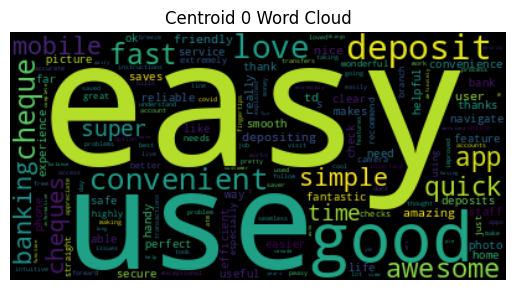

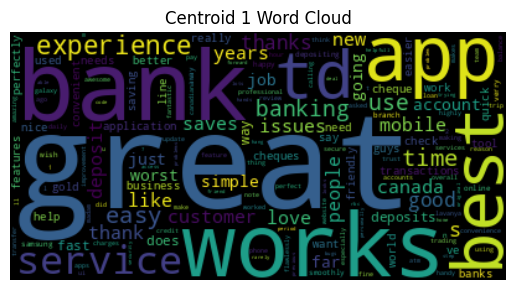

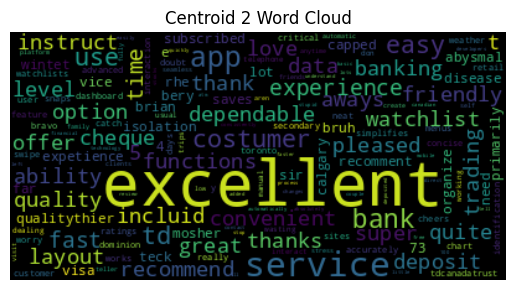

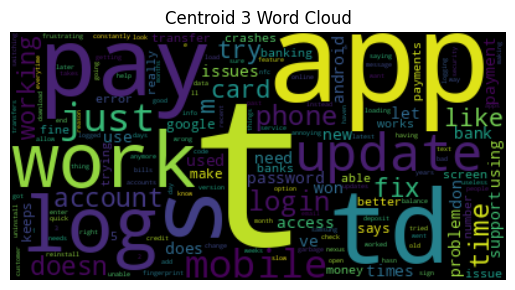

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i, centroid in enumerate(centroids):
    wc = WordCloud(width=400, height=200)
    wc.generate_from_frequencies(centroid)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Centroid {i} Word Cloud")
    plt.show()



## Summary

In this lecture, we explored the full journey from **raw text reviews** to **meaningful insights**:

- We used `google-play-scraper` to collect real app review data.
- We built custom tokenizers and vectorization functions for Binary, TF, and TF-IDF models.
- We learned how to represent text as sparse vectors and use them in sentiment scoring.
- We evaluated a **lexicon-based sentiment model** by comparing predicted sentiment scores to real user ratings.
- We introduced **cosine similarity** to measure document similarity.
- We implemented **K-means clustering** from scratch to discover themes in user reviews.
- Finally, we visualized and interpreted clusters using word clouds and average ratings.

This workflow demonstrates how to turn unstructured customer feedback into actionable insights — a critical capability in business analytics.

## Exercises

Try the following exercises to reinforce this week’s concepts:

1. Try re-running the k-means clustering. How stable are the clusters?

2. Try repeating the analysis with varying numbers of clusters. What number gives the best results?

3. Repeat this analysis using a different app or even another dataset.

4. Think about how you would present these results to a business audience. What advice would you give them?

## Homework

- Read chapters 10 thru 15 of [Think Python](https://allendowney.github.io/ThinkPython/)
- Complete the Exercises above
- Get going on your Group Project